In [1]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import xml.etree.ElementTree as etree
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse_annot(annot_file_path):
    # returns the bounding box coords and class agonistic centers for each object in annot file
    results = {}
    #centers = []
    xml_file = etree.parse(annot_file_path)
    root = xml_file.getroot()
    #img_height = xml_file.findtext('.//height')
    #img_width = xml_file.findtext('.//width') 
    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls not in results.keys():
            results[cls] = []
        xmin = int(round(float(obj.find('bndbox').find('xmin').text)))
        ymin = int(round(float(obj.find('bndbox').find('ymin').text)))
        xmax = int(round(float(obj.find('bndbox').find('xmax').text)))
        ymax = int(round(float(obj.find('bndbox').find('ymax').text)))
        coords = [xmin, ymin, xmax, ymax]
        #center = get_center(coords)
        #centers.append(center)
        results[cls].append(coords)
    return results#, centers

In [3]:
def get_center(coords):
    
    x = (coords[0] + coords[2]) / 2.0
    y = (coords[1] + coords[3]) / 2.0
    
    return[x, y]

In [4]:
def get_grid_info(img_size, grid_size):
    coords = []
    centers = []
    # assuming grid and img size are symmetric
    each_grid = img_size[0] / grid_size[0]
    xmin, ymin = (0, 0)
    xmax, ymax = int(each_grid), int(each_grid)
    for each_grid in range(grid_size[0] * grid_size[1]):
        width = xmax - xmin
        height  = ymax - ymin
        bbox = [xmin, ymin, xmax, ymax]
        centers.append(get_center(bbox))
        coords.append(bbox)
        if (each_grid + 1) % grid_size[0] !=0:
            xmin = xmax
            ymin = ymin
            xmax = xmin + width
            ymax = ymin + height
        else:
            xmin = 0
            ymin = ymax 
            xmax = xmin + width
            ymax = ymin + height
    return coords, centers

In [6]:
def find_object_grid(object_centers, grid_centers):
    
    #grid_coord, grid_centers = get_grid_info(img_size=input_size, grid_size=grid_size)
    grid_centers = np.asarray(grid_centers, dtype=float)
    box_nums = []
    if len(object_centers) > 2:
        for center in object_centers:
            box_num = np.argmin(np.sqrt(np.sum(np.square(grid_centers - center), axis=1)))
            box_nums.append(box_num)
    else:
            box_num = np.argmin(np.sqrt(np.sum(np.square(grid_centers - object_centers), axis=1)))
            return box_num
    return box_nums

#### The flow of the parsing annotations would be as follows

   1. Parse the annotation file to get the classes with their bounding box information and centers *parse_annot()*  
   1. To find where each object falls in the grid
        1. Transform the image to fixed image size say 224x224 and then transform the bbox coords and object centers
        1. Make the grid by calling *get_grid_info()* which returns grid coordinates and grid centers
        1. Get the centers of each object after parsing the annotation file
        1. Compare the distance between the object centers and grid centers and get the args of least distance *find_object_grid()*

In [7]:
import numpy as np
from skimage.io import imread
from skimage.transform import resize

class DataGenerator(object):

    def __init__(self, dim_x = 224, dim_y = 224, channels = 3, grid_size=(3, 3), batch_size = 32, img_path=None, shuffle = True):
        'Initialization'
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_z = channels
        self.grid_size = grid_size
        self.batch_size = batch_size
        self.img_path = img_path
        self.shuffle = shuffle

    def generate(self, labels, list_IDs):
        'Generates batches of samples'
        # Infinite loop
        while 1:
        # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
            # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                # Generate data
                X, y = self.__data_generation(labels, list_IDs_temp)

                yield X, y

    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)
        return indexes

    def __data_generation(self, labels, list_IDs_temp):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = np.empty((self.batch_size, self.dim_x, self.dim_y, self.dim_z))
        y = np.empty((self.batch_size, 4), dtype = int)
        new_y = np.zeros(shape=(self.batch_size, self.grid_size[0], self.grid_size[1], 5), dtype=int)
        
        grid_coords, grid_centers = get_grid_info(img_size=(self.dim_x, self.dim_y), grid_size=(self.grid_size[0], self.grid_size[1]))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            #img = imread('./images/'+ID+'.jpg')
            img = imread(self.img_path + ID + '.jpg')
            real_h, real_w, c = img.shape
            img = resize(img, (self.dim_x, self.dim_y), mode='reflect')
            
            X[i] = img

            # Store volume
            #X[i, :, :, :, 0] = np.load(ID + '.npy')

            # Fixing the bbox after image resize
            bbox_list = labels[ID]
            for each_bbox in bbox_list:
                xmin = int(each_bbox[0] * self.dim_x / real_w)
                xmin = max(min(xmin, real_w), 0)
                xmax = int(each_bbox[2] * self.dim_x / real_w)
                xmax = max(min(xmax, real_w), 0)
                ymin = int(each_bbox[1] * self.dim_y / real_h)
                ymin = max(min(ymin, real_h), 0)
                ymax = int(each_bbox[3] * self.dim_y / real_h)
                ymax = max(min(ymax, real_h), 0)
            
                coords = (xmin, ymin, xmax, ymax)
                obj_center = get_center(coords)
                grid_arg = find_object_grid(object_centers=obj_center, grid_centers=grid_centers)
            #print(obj_center, grid_args)
                
                new_y[i, grid_arg // self.grid_size[0], grid_arg % self.grid_size[0] , : ] = [1, xmin, ymin, xmax, ymax]
            #y[i] = coords

        return X, new_y


In [8]:
with open('full_final_partition.pkl', 'rb') as infile:
    final_parition = pickle.load(infile)
with open('all_labels_only_bboxes.pkl', 'rb') as infile:
    lables = pickle.load(infile)

In [9]:
params = {'dim_x': 224,
          'dim_y': 224,
          'channels': 3,
          'grid_size':(5, 5),
          'batch_size': 16,
          'img_path':'../../../VOCdevkit/images/',
          'shuffle': False}

# Datasets
partition = final_parition # IDs
labels = lables # Labels

# Generators
training_generator = DataGenerator(**params).generate(labels, partition['train'])
validation_generator = DataGenerator(**params).generate(labels, partition['val'])

In [10]:
count = 0
for x_train, y_train in training_generator:
    print(x_train.shape, y_train.shape)
    count +=1
    if count == 5:
        break

(16, 224, 224, 3) (16, 5, 5, 5)
(16, 224, 224, 3) (16, 5, 5, 5)
(16, 224, 224, 3) (16, 5, 5, 5)
(16, 224, 224, 3) (16, 5, 5, 5)
(16, 224, 224, 3) (16, 5, 5, 5)


In [12]:
y_train[2]

array([[[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1, 123,  85, 177, 111],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  1,  48,  68, 166, 197],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]],

       [[  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0]]])

In [13]:
final_parition['train'][66]

'2010_000908'

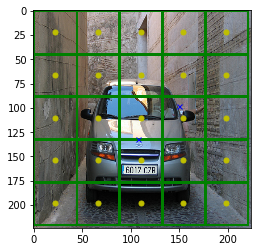

In [17]:
img = imread('../../../VOCdevkit/images/'+'2010_000908.jpg')
visualize_grid_with_gt(img=img, grid_size=(5, 5), y_vector=y_train[2], img_resize=(224, 224))

In [14]:
def visualize_grid_with_gt(img, y_vector, img_resize, grid_size=(3, 3)):
    
    grid_x, grid_y, preds = y_vector.shape
    real_h, real_w, c = img.shape
    img = resize(img, img_resize, mode='reflect')
    plt.imshow(img)
    coords, centers = get_grid_info(img_size=img_resize, grid_size=(grid_size[0], grid_size[1]))
    grid_num = 0
    for each_grid_coords, each_grid_center in zip(coords, centers):
        plt.gca().add_patch(plt.Rectangle((each_grid_coords[0], each_grid_coords[1]), each_grid_coords[2] - each_grid_coords[0] + 1, each_grid_coords[3] - each_grid_coords[1]+1, fill=False, edgecolor='g', linewidth=2))
        plt.plot(each_grid_center[0], each_grid_center[1], marker='o', markersize=5, color='y')
        single_vector = y_vector[grid_num // grid_x , grid_num % grid_y, : ]
        if  np.sum(single_vector) == 0:
            pass
        else:
            obj_center = get_center(single_vector[1:])
            plt.plot(obj_center[0],obj_center[1], marker='x', markersize=5, color='b')
        grid_num += 1
    plt.show()

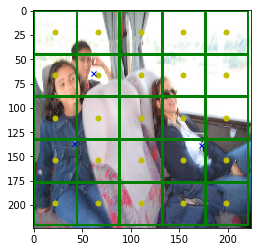

In [289]:
visualize_grid_with_gt(test_img, test[1], (224, 224))